[EP09]인물사진을 만들어 보자

<<목차>>

1) 인물모드 직접 해 보기
2) 사진에서 문제점 찾기
3) 해결 방법을 제안해 보기
4) 루브릭
5) 회고

1) 인물모드 직접 해 보기

배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)

시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.

블러링(blurring) 기술로 배경을 흐리게 합니다.

피사체를 배경의 원래 위치에 합성합니다.

In [38]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
import pixellib
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import tensorflow as tf


(2114, 3000, 3)


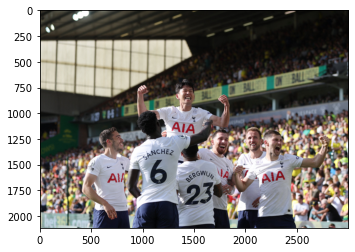

In [39]:
img_path = '/home/june/pics/sonny.jpg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)
img = mpimg.imread(img_path)
plt.imshow(img)

In [40]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [41]:
_DOWNLOAD_URL_PREFIX = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

model_dir = '/home/june/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):  # path 오류날 시, url에서 직접 요청
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                             download_path)

MODEL = DeepLabModel(download_path)

temp directory: /home/june/human_segmentation/models


2022-10-20 14:34:13.930610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 14:34:13.930833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 14:34:13.930998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 14:34:13.931188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 14:34:13.931341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [42]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(2114, 3000, 3) (361, 513, 3) 15


In [43]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

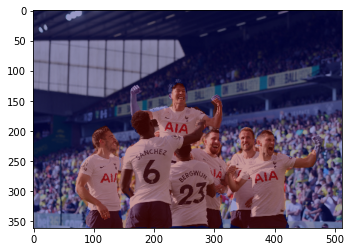

In [44]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # human => 15th
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

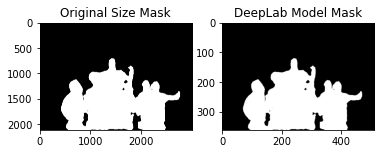

In [45]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

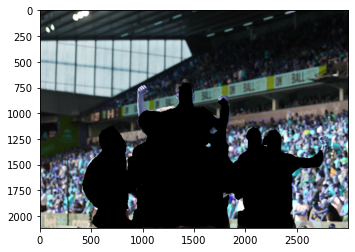

In [46]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

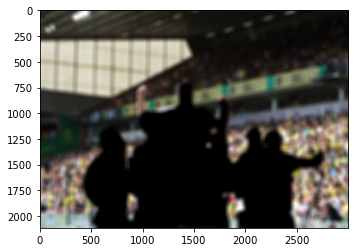

In [47]:
img_bg_blur = cv2.blur(img_bg, (50,50))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

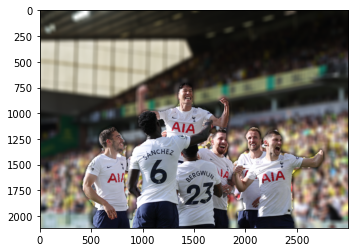

In [48]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

이미 배경이 아웃포커싱이 되어있는 상태의 사진에 블러를 더 많이 입혔더니 약간의 괴리감이 든다. 

★2차시도

(675, 1200, 3)


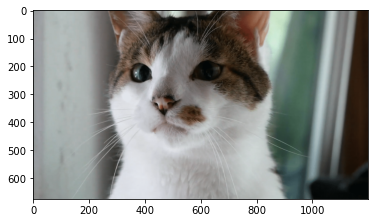

In [49]:
img_path = '/home/june/pics/mu.png'
img_orig = cv2.imread(img_path)
print(img_orig.shape)
img = mpimg.imread(img_path)
plt.imshow(img)

In [50]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(675, 1200, 3) (288, 513, 3) 8


In [51]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

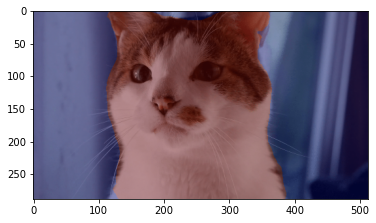

In [52]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # cat -> 8
img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

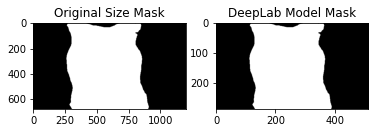

In [53]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

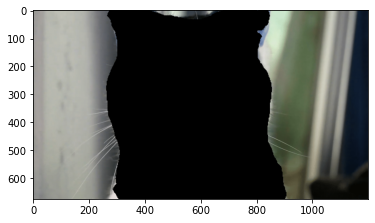

In [54]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) 
plt.imshow(img_bg)
plt.show()

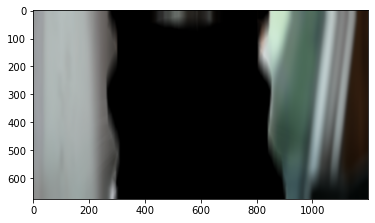

In [55]:
img_bg_blur = cv2.blur(img_bg, (5,90)) 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

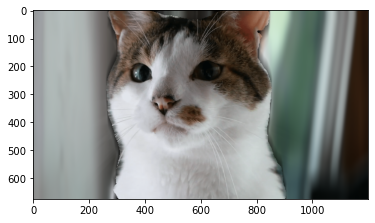

In [56]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

★3차시도

(1029, 1920, 3)


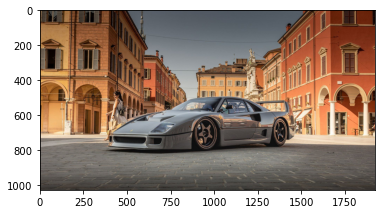

In [57]:
img_path = '/home/june/pics/f401.jpg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)
img = mpimg.imread(img_path)
plt.imshow(img)

In [58]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1029, 1920, 3) (274, 513, 3) 15


'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    
차는 7번이다

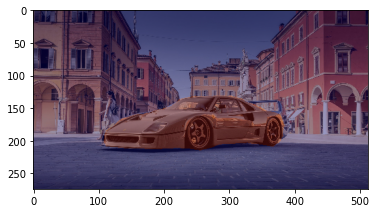

In [75]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 7, 7, 0) # car -> 7
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

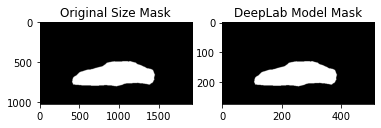

In [60]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

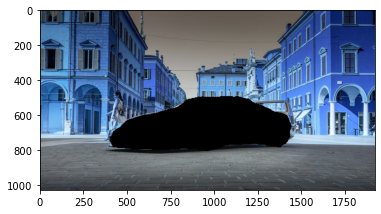

In [61]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) 
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) 
plt.imshow(img_bg)
plt.show()

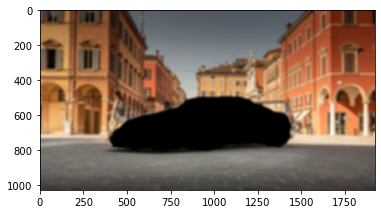

In [62]:
img_bg_blur = cv2.blur(img_bg, (18,18)) 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

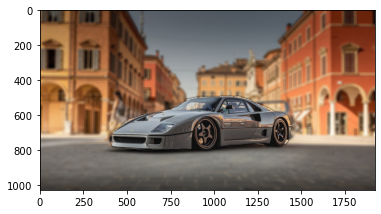

In [63]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.savefig('F401_bgblurrVER.png', dpi=800)
plt.show()

멋지게 뽑힌것 같다. 이제 배경을 바꿔보자.

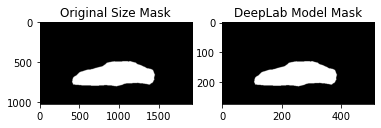

In [64]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [65]:
img_path = '/home/june/pics/kintex.jpg'
img_bg = cv2.imread(img_path) 
print (img_bg.shape)

(600, 1200, 3)


In [66]:
target_size = img_orig.shape[:2][::-1]
resized_universe = cv2.resize(img_bg, target_size)
print(resized_universe.shape)

(1029, 1920, 3)


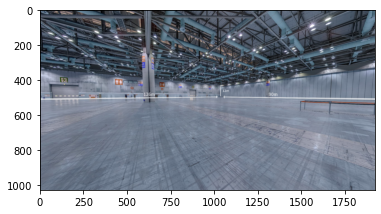

In [67]:
plt.imshow(resized_universe)
plt.show()

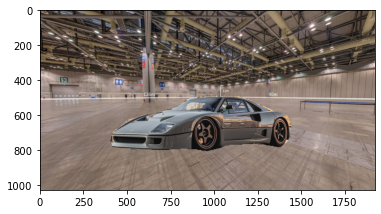

In [68]:
img_concat = np.where(img_mask_color==255, img_orig, resized_universe)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

언젠가 한국에서 볼 수 있기를 바라며 대충 일산 킨텍스 공식홈페이지에서 전시장 내부사진을 퍼왔다.

2) 사진에서 문제점 찾기

문제점들이 여럿 발견 되었다.

1_동물 사진의 경우에는 털이나 수염 등 털 부분을 세밀하게 잡지 못한다.

2_자동차의 스포일러를 잡지못해 뒷부분이 허전해졌다.

3_블러처리로 인해 인물(object)과 배경과의 괴리, 경계선의 검은색이 짙어진다. 특히 털이있는 동물 사진에서 두드러진다.

3) 해결 방법을 제안해 보기

1_모델을 바꿔보는것도 방법이겠다. Deeplab V3+ 가 V3보다 더세밀하게 잡을수 있지 않을까?? 직접 해봐야겠다.

2_이또한 모델을 바꿈으로써 해결될수 있는 부분이라고 생각한다.  딥랩v3는 매우 훌륭한 모델이지만 SeNET, EfficientNET, UNET 등 뭐시기-Net 모델종류로 바꾸면  segmentation에서의 향상된 성능을 보여줄수 있지 않을까?

3_모델(obj) 경계에 가우시안 블러를 함으로써 개선효과를 기대했는데 별 효과는 없는것 같아 포기했고, 일단 블러의 가로 블러값은 줄이고 세로 블러값을 늘려 기존의 블러량은 유지하되 경계선이 덜 퍼지는 효과를 얻었다.

4) 루브릭

1. 인물모드 사진을 성공적으로 제작하였다.

아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.


2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.

인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.


3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.

semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.

5) 회고

- 이번 프로젝트에서 **어려웠던 점,**

아직 코드 만드는게 익숙치 않음.

사진도 잘 골라서 진행해야한다. 그렇지 않으면 사진을 자꾸 바꿔야해서 번거롭다.

모델에 대한 이해도 부족.


- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**

Image segmentation에 적용할 수 있는 다양한 모델들을 알 게 되었지만 아직 각 모델들의 특징, 장단점등은 알지 못한다.


- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**

주어진 모델을 사용하기에 바꿀수 있는점이 많지 않았지만 사진을 바꿔보고, 블러 값도 바꿔보는 등 나름대로의 다양하게 시도하였음.


- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**


- **자기 다짐**

CNN과 Image segmentation 모델들에 관한 심도있는 공부가 필요할 것 같다. 이는 곧 CV심화반에서도 사용하게 될것이다.